# 1. Introduction

    What is the input data?
    What type of problem? Multiclass singlelabel classification
    Terminology

Using a magnifying glass to identify objects from your phone is ridiculous. Right? Object detection in low quality images such as an online avatars or compressed .jpegs is often overshadowed by the same problem concerning textual applications. Increasingly higher resolution screens make this an impending problem related to accessibility that the minor population eg. elderly may appreciate. 

A proposal that when translated to machine learning, will be a computer vision problem. The solution is a trained model capable of learning the pixel mappings to real life objects. With it comes considerations such as dimensionality, object detection, and data set context.

A common collection of images for our task, `cifar10`, is an image classification data set. It contains 60,000 images of 32x32 dimension with 3 colour channels. Each sample contains pixel data for one of ten labels, making this problem a **multi-class single-label** classification task.

### Aims and Objectives

This notebook, will follow Francis Challot's Deep Learning Workflow to:
- Prepare the input data
- Develop a baseline model
- Develop a better model that will overfit
- Regularize the model while improving loss and accuracy

At the end of the notebook, the final model should:
- Cohere to stable a convolutional neural network architecture
- Successfully classify images from the `cifar10` data set into one of 10 classes
- Predict unseen data with higher accuracy than a random model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


%matplotlib inline

In [2]:
import tensorflow as tf
import keras
from keras import models, layers, regularizers, optimizers
from keras.datasets import cifar10


# empty array to store future model information
model_summary = []

# load data from library
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'{X_train.shape[0]} train samples')
print(f'{X_test.shape[0]} test samples')

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [3]:
# examine data in first sample with label
print(f'first sample:\n{X_train[0][0][:5]}\n...\n')
print(f'first label: {y_train[0]}')

first sample:
[[59 62 63]
 [43 46 45]
 [50 48 43]
 [68 54 42]
 [98 73 52]]
...

first label: [6]


# 2. Choosing a measure of success

To start, the validation loss convergence and the lowest loss of the model will be used to quantify success. A low validation loss and a high accuracy model is ideal. Monitoring loss has precedence over accuracy, but accuracy will be considered on the basis loss between models is similar (assuming it is not overfitting). There will be a trial-and-error cycle of selecting reasonable rates for hyperparameters, training the model, and analyzing the performance by graphical comparison. An "Observation & Thoughts" section will conclude exploratory findings and select the best model to use.

At the end of the notebook, the final model will have a more detailed analysis examining the test predictions in a confusion matrix, with predictions presented as a heatmap.

In [4]:
# mapping of label to names
target_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"}

# save list of string names
classes = np.arange(0, 10, 1)
class_names = [target_names[name] for name in classes]

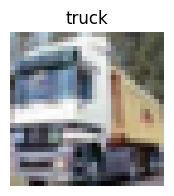

In [5]:
def plot_sample(sample=X_train[0], label=6):
    """
    plot a single pixel image sample
    """
    data = sample

    # set plot parameters
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.title(target_names[label])

    # Use imshow to plot pixels
    plt.imshow(data)

    # Display the plot
    plt.show()

# show an example
plot_sample(X_train[1], y_train[1][0])

12 sample plot


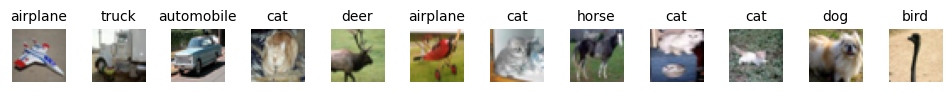

In [6]:
def plot_multi_sample(samples=X_train[0:8], labels=[6, 9, 9, 4, 1, 1, 2, 7],
                      pred_labels=None, name='sample plot'):
    """
    plot pixel image data using matplotlib
    by default displays 10 samples at a time
    """
    length = len(samples)

    # create horizontal figure with subplots
    fig, axes = plt.subplots(1, length, figsize=(12, 6))
    axes = axes.flatten()

    # create subplot for each image data
    for i in range(length):
        data = samples[i]
        label = labels[i]

        # plot parameters
        plt.subplot(1, length, i+1)
        plt.axis('off')

        if pred_labels is not None:
            plt.title(f'True: {target_names[labels[i]]}\nPred: {target_names[pred_labels[i]]}',
                      fontsize=10)
        else:
            plt.title(target_names[labels[i]],
                      fontsize=10)
        plt.subplots_adjust(wspace=0.5)
        plt.imshow(samples[i])

    # display sample count and show plot
    print(f'{length} {name}')
    plt.show()

# show some examples
plot_multi_sample(X_train[30:42], [y[0] for y in y_train[30:42]])

# 3. Evaluation Protocol

The `cifar10` data set is sufficiently large enough with 50,000 training samples that hold-out validation can be used. A 10,000 validation set will be split from the training set, reducing the original training set to a partial 40,000.

Using `train_test_split` from the sklearn library, we can ensure the data is still balanced after the split by setting `stratify=y_train`.

In [7]:
# split into validation data and partial training data
# stratify=y_train to ensure even porportion of split labels
x_partial, x_val, y_partial, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

print(x_partial.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

40000 train samples
10000 validation samples
10000 test samples


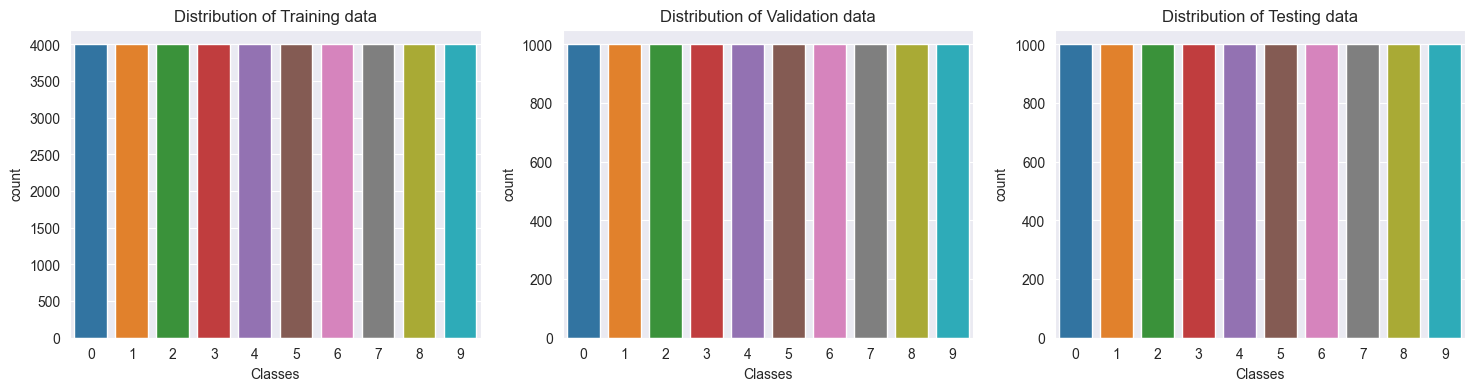

In [8]:
# show distribution of samples by countplot
# check the split data is balanced
sns.set_style("darkgrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
# plot for training set
sns.countplot(x=y_partial.ravel(), ax=axes[0])
axes[0].set_title('Distribution of Training data')
axes[0].set_xlabel('Classes')

# plot for validation set
sns.countplot(x=y_val.ravel(), ax=axes[1])
axes[1].set_title('Distribution of Validation data')
axes[1].set_xlabel('Classes')

# plot for testing set
sns.countplot(x=y_test.ravel(), ax=axes[2])
axes[2].set_title('Distribution of Testing data')
axes[2].set_xlabel('Classes')
plt.show()

# 4. Preprocessing Data

To keep gradient updates small, and data homogenous, samples are vectorized before input into a neural network. Each sample is in the shape `(32, 32, 3)`, equivalent to the width, length dimensions, and image colour channels each pixel retains. Each number in the tensor is an integer in the range [0, 255], which will be normalized by casting to float and division by 255 to the range of [0, 1].

The data set labels are integer values from [0, 9], each of which will be one-hot encoded to a single vector of 0's and a 1. 

In [9]:
def prep_normalize(data):
    """
    normalizes pixel data (RGB colour channels) to range to [0,1]
    convert data type to float and divide by 255
    """
    data = data.astype('float32') / 255
    return data


def prep_encoder(data, classes=10):
    """
    one-hot encode data to n-class categories
    """
    data = tf.keras.utils.to_categorical(
        data, num_classes=classes, dtype='float32'
    )
    return data

In [10]:
# normalize samples
x_partial = prep_normalize(x_partial)
x_val = prep_normalize(x_val)
x_test = prep_normalize(X_test)

# one-hot encode labels
y_partial = prep_encoder(y_partial)
y_val = prep_encoder(y_val)

y_test = y_test.ravel()

# show normalized training data
print(x_partial)
print(y_partial)

[[[[0.44705883 0.72156864 0.8509804 ]
   [0.4392157  0.70980394 0.8392157 ]
   [0.44313726 0.70980394 0.8392157 ]
   ...
   [0.4392157  0.7019608  0.84313726]
   [0.43529412 0.7019608  0.84313726]
   [0.43529412 0.7058824  0.84313726]]

  [[0.44705883 0.72156864 0.84705883]
   [0.4392157  0.70980394 0.8352941 ]
   [0.44313726 0.70980394 0.8352941 ]
   ...
   [0.43137255 0.69803923 0.83137256]
   [0.43137255 0.7019608  0.83137256]
   [0.43529412 0.70980394 0.8392157 ]]

  [[0.45490196 0.73333335 0.84705883]
   [0.44313726 0.7176471  0.827451  ]
   [0.44313726 0.7137255  0.827451  ]
   ...
   [0.43137255 0.7019608  0.83137256]
   [0.43137255 0.7019608  0.83137256]
   [0.43137255 0.70980394 0.83137256]]

  ...

  [[0.8784314  0.78039217 0.6039216 ]
   [0.83137256 0.7372549  0.5647059 ]
   [0.8235294  0.7294118  0.5568628 ]
   ...
   [0.8666667  0.74509805 0.5372549 ]
   [0.8392157  0.7176471  0.5058824 ]
   [0.84705883 0.73333335 0.52156866]]

  [[0.8392157  0.7411765  0.5686275 ]
   [0.8

In [11]:
# helper functions

def plot_history(history, name='Model'):
    """
    function to plot loss and accuracy based on model history
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # plot training & valid loss
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title(f'{name} Loss History')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Training', 'Validation'])
    axes[0].grid(linestyle='dotted')
    # axes[0].legend(['Training', 'Validation'], loc='upper left')

    # plot training & valid accuracy
    axes[1].plot(history.history['accuracy'])
    axes[1].plot(history.history['val_accuracy'])
    axes[1].set_title(f'{name} Accuracy History')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Training', 'Validation'])
    axes[1].grid(linestyle='dotted')
    plt.show()


# loss and accuracy with testing set
def evaluate_model(model):
    """
    evaluates model with testing set and returns results
    """
    loss, acc = model.evaluate(x_test, prep_encoder(y_test), verbose=0)
    print(f'Test loss: {loss}')
    print(f'Test accu: {acc}')
    return loss, acc


def optimal_epoch(history):
    """
    returns epoch index with lowest loss and highest accuracy
    """
    min_loss = np.argmin(history.history['val_loss'])
    max_accu = np.argmax(history.history["val_accuracy"])
    print(f'Min loss at epoch: {min_loss}')
    print(f'Max accu at epoch: {max_accu}')
    return min_loss, max_accu


In [12]:
# more helper functions

def smooth(y, box_pts):
    """
    smooth data moving average over box_pots points
    adapted from #answer-26337730 [2]
    """
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def plot_history_comparison(histories, legend_names, title, lim=None, dotted=None):
    """
    plot multiple loss and accuracy graphs in on one figure
    """
    SMOOTH_N = 10  # number of last datapoints to average

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # plot training & valid loss for multiple models
    for i, history in enumerate(histories):
        # truncate and smooth data before plotting
        data = smooth(history.history['val_loss'], SMOOTH_N)
        if lim:
            data = data[SMOOTH_N:lim]
        if dotted and i+1 in dotted:
            axes[0].plot(data, linestyle='dotted')
        else:
            axes[0].plot(data)
    axes[0].set_title(f'{title} Validation Loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(legend_names)
    axes[0].grid(linestyle='dotted')

    # plot training & valid accuracy
    for i, history in enumerate(histories):
        # truncade and smooth data before plotting
        data = smooth(history.history['val_accuracy'], SMOOTH_N)
        if lim:
            data = data[SMOOTH_N:lim]
        if dotted and i+1 in dotted:
            axes[1].plot(data, linestyle='dotted')
        else:
            axes[1].plot(data)
    axes[1].set_title(f'{title} Validation Accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(legend_names)
    axes[1].grid(linestyle='dotted')
    plt.show()

In [13]:
# even more helper functions

def plot_pred_count(y_data, index=None, title=''):
    """
    countplot based on given index
    used for true positive, false positive
    """
    if index.any():
        print(f'total={len(index)}')

    # plot errors
    fig, ax = plt.subplots(figsize=(10, 4))
    if index.any():
        sns.countplot(x=y_data[index])
    else:
        sns.countplot(x=y_data)
    ax.set_xlabel('Classes')
    ax.set_xticklabels(class_names)
    ax.set_title(title)
    plt.show()


def plot_pred_heatmap(y_true, y_pred, title='model'):
    """
    plot prediction data as confusion matrix,
    beautify as sns heatmap
    """
    data = confusion_matrix(y_true, y_pred)
    # print(data)
    ax = sns.heatmap(data, annot=True, fmt=".0f", cmap='rocket_r')
    ax.set(xlabel="Predicted", ylabel="True")
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.title(f'{title} True vs Prediction Heatmap')
    plt.show()


# 5. Developing a Baseline Model

For a baseline model, we'll stick to using the bare minimum neural network. The shape of the input data has 32 width, so our first dense layer will be equally wide. There are ten labels in our data set, so another dense layer will output ten probabilties. A flatten layer will sit between the dense layers to make sure we get appropriate shape transformations for dimensionality reduction.

For default hyperparameters, we'll use the `rmsprop` from the Keras library as the optimizer. Challot recommends the `categorical_crossentropy` loss function and `softmax` last layer activation for the multi-class single-label classification [[6](https://tanthiamhuat.files.wordpress.com/2018/03/deeplearningwithpython.pdf)]. The compiler metric will be `accuracy`.

A random model would have 10% prediction accuracy for this data set. Lets see how the baseline model does.

In [14]:
def dense_baseline_model():
    """
    baseline two dense layer model width:32
    """
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu',
              input_shape=X_train[0].shape))
    model.add(layers.Flatten())  # flatten dimensions before output
    model.add(layers.Dense(10, activation='softmax'))

    # hyperparameters
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [15]:
# view the model summary
base_model = dense_baseline_model()
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32, 32, 32)        128       
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                327690    
                                                                 
Total params: 327,818
Trainable params: 327,818
Non-trainable params: 0
_________________________________________________________________


In [16]:
# set epochs and batch_size
N_EPOCHS = 100
BATCH_SIZE = 64


base_history = base_model.fit(x_partial, y_partial,
                    validation_data=(x_val, y_val),
                    epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                    verbose=0)

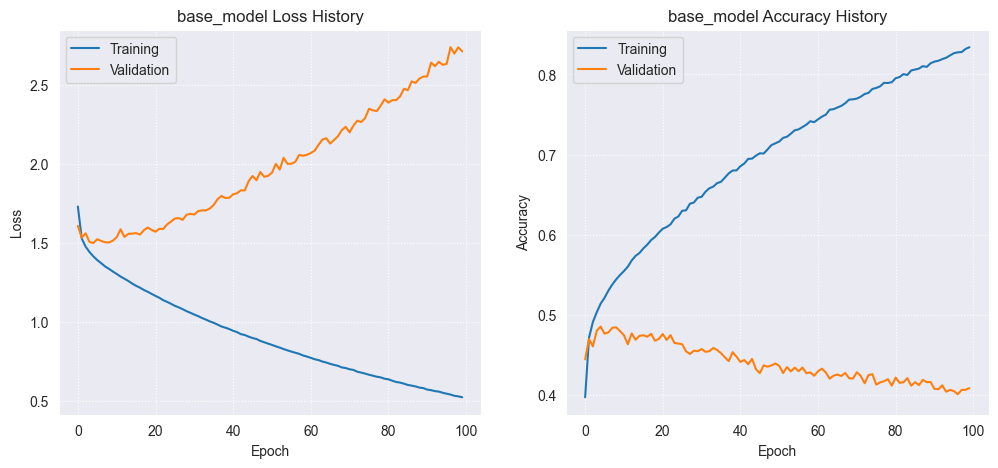

In [17]:
plot_history(base_history, 'base_model')

In [18]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(base_model)

# get optimal epoch
loss_epoch, accu_epoch = optimal_epoch(base_history)
lowest_loss = base_history.history['val_loss'][loss_epoch]

# store results in dataframe
model_summary.append(['base_model', N_EPOCHS, BATCH_SIZE, 0, 32, base_model.count_params(),
                      '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])

Test loss: 2.6589887142181396
Test accu: 0.40460002422332764
Min loss at epoch: 4
Max accu at epoch: 4


Number of correct predictions: 4046/10000
Prediction accuracy: 0.40459999999999996
10 sample plot


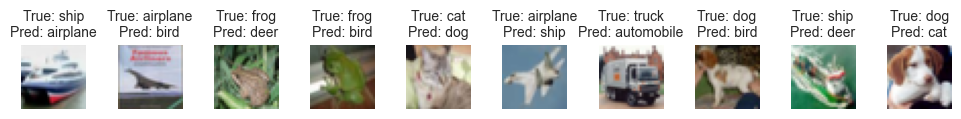

In [19]:
# use trained model to predict testing data, same as model.evaluate()
y_pred = base_model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

# get index count of false predictions
errors = np.sum(y_pred != y_test)
errors_index = np.where(y_pred != y_test)[0]
test_samples = len(y_pred)

print(f'Number of correct predictions: {test_samples-errors}/{test_samples}')
print(f'Prediction accuracy: {1-errors/test_samples}')

# plot incorrect preditions, true vs predicted labels
plot_multi_sample(X_test[errors_index][:10],
                  y_test[errors_index][:10].ravel(),
                  y_pred[errors_index][:10])

### Observations & Thoughts on Baseline Model
- The baseline model overfits almost immediately
- Validation loss is very high and does not decrease from training
- Validation accuracy is very low and barely increases from training

The baseline model achieves an accuracy of ~40% meaning it does better than a random classifier, however high loss and low accuracy means the model is a poor predictor of unseen data and fails to generalize. This is as expected from a shallow model lacking depth, complexity, and consideration from the data set. For our goal, there are many improvements left to make.

# 6. Overfitting a Convolutional Model

In context of our task being image classification, convolutional layers should perform better than dense layers in a deep learning model. Therefore, understanding convolutional architecture is pivotal to achieving good results. In this section we'll start to create and modify a convolutional model.

Examining historically successful CNNs, such as AlexNet and VGG16, shows a common trend of stacking deep learning layers as 'blocks' or 'stacks', where each 'block' contains >two conv2d layers and one maxpooling layer. It shifts the need of testing different filter and layer configurations, instead proposing frameworks where successive blocks double the layer sizes. This architecture makes means of utilizing network depth to achieve good learning results.

> The width of convolutional layers (the number of channels) is rather small, starting from 64 in the first layer and then increasing by a factor of 2 after each max-pooling layer, until it reaches 512. [[2](https://arxiv.org/pdf/1409.1556.pdf)]

In theory, this design adds robustness to noise and helps make a more flexible model, at the risk of more overfitting. [[1](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)]

In [20]:
def conv2d_model(blocks=1, optimizer='rmsprop', layer_size=1, padding='valid'):
    """
    basic conv2d model without dropout
    convolutional architecture following vgg16
    """
    model = models.Sequential()

    # block 1
    model.add(layers.Conv2D(32 * layer_size, (3, 3),
                            activation='relu',
                            padding=padding,
                            input_shape=X_train[0].shape))
    model.add(layers.Conv2D(32 * layer_size, (3, 3),
              activation='relu', padding=padding))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # block 2
    if blocks > 1:
        model.add(layers.Conv2D(64 * layer_size, (3, 3),
                  activation='relu', padding=padding))
        model.add(layers.Conv2D(64 * layer_size, (3, 3),
                  activation='relu', padding=padding))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # block 3
    if blocks > 2:
        model.add(layers.Conv2D(128 * layer_size, (3, 3),
                  activation='relu', padding=padding))
        model.add(layers.Conv2D(128 * layer_size, (3, 3),
                  activation='relu', padding=padding))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # head output
    model.add(layers.Flatten())
    model.add(layers.Dense(64 * np.power(2, blocks-1) * layer_size))
    model.add(layers.Dense(10, activation='softmax'))

    # hyperparameters
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

## 6.1 A Problem with Increasing Layer Depth

The major differences with our approach verus AlexNet or VGG16 is that their input samples are of sizes 224x224 while `cifar10` images are 32x32. By default, it is impossible for us to create model with more than two blocks of maxpooling, because spatial dimensions are reduced too quickly.

Showcased with two models below, is an example of this happening. Note the rate of decreasing layer shape in the **block2_model**; it has a shape of `(5, 5, 64)` by the end of block two. When the depth is increased to `blocks=3`, **block3_model** throws an error about "Negative dimension size".

In [84]:
# example of an unpadded two block model
# note the output shape at the max_pooling layers
block2_model = conv2d_model(blocks=2)
block2_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 conv2d_129 (Conv2D)         (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_130 (Conv2D)         (None, 12, 12, 64)        18496     
                                                                 
 conv2d_131 (Conv2D)         (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                

In [85]:
# example of error being thrown due to negative dimensions
block3_model = conv2d_model(blocks=3)
block3_model.summary()

ValueError: Exception encountered when calling layer "max_pooling2d_68" (type MaxPooling2D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_68/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,1,128].

Call arguments received by layer "max_pooling2d_68" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 1, 1, 128), dtype=float32)

### Adding Kernal Padding

One 'hacky' way to overcome this issue is to add padding of 0's around the 3x3 kernel filter. We can specify this to Keras by setting `padding='same'` [[5](https://keras.io/api/layers/convolution_layers/convolution2d/)]. This will artifically increase the filter sizes, reducing the rate of spatial reduction between conv2d layers, and allows specifying a third block in our block. An example of modified kernal filter is shown after training.

In [21]:
# finally let's test some different model configurations

"""
The following code is equivalent to training and evaluating models:
model_b1   = conv2d_model(blocks=1)
model_b2   = conv2d_model(blocks=2)
model_b2s2 = conv2d_model(blocks=2, layer_size=2)
model_b3   = conv2d_model(blocks=3, padding='same')
model_b3s2 = conv2d_model(blocks=3, layer_size=2, padding='same')
"""

N_EPOCHS = 100
BATCH_SIZE = 128

# define hyperparameters for models, each element represents a model
params_size = [['model_b1',   1, 1, 'valid'],
               ['model_b2',   2, 1, 'valid'],
               ['model_b2s2', 2, 2, 'valid'],
               ['model_b3',   3, 1, 'same'],
               ['model_b3s2', 3, 2, 'same']]

models_size = []
histories_size = []

# loop over hyperparameters and create models
for i, param in enumerate(params_size):
    model = conv2d_model(blocks=param[1],
                         layer_size=param[2],
                         padding=param[3])

    # train model
    history = model.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=0)

    # save model and history in arrays
    models_size.append(model)
    histories_size.append(history)

    # evaluate loss and accuracy data
    print(f'------------{param[0]}------------')
    loss_test, accu_test = evaluate_model(model)
    loss_epoch, accu_epoch = optimal_epoch(history)
    lowest_loss = history.history['val_loss'][loss_epoch]

    # store results for dataframe
    layer_size = 64 * np.power(2, param[1]-1) * param[2]
    model_summary.append([param[0], N_EPOCHS, BATCH_SIZE, param[1], layer_size, model.count_params(),
                          '-', 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])


# check models and histories are saved at end of runtime
print(f'{len(models_size)} models and {len(histories_size)} histories saved')

------------model_b1------------
Test loss: 6.618343830108643
Test accu: 0.5869000554084778
Min loss at epoch: 3
Max accu at epoch: 6
------------model_b2------------
Test loss: 3.579756021499634
Test accu: 0.7032000422477722
Min loss at epoch: 9
Max accu at epoch: 10
------------model_b2s2------------
Test loss: 4.395211696624756
Test accu: 0.7380000352859497
Min loss at epoch: 5
Max accu at epoch: 35
------------model_b3------------
Test loss: 4.238517761230469
Test accu: 0.7289000153541565
Min loss at epoch: 7
Max accu at epoch: 92
------------model_b3s2------------
Test loss: 6.52072811126709
Test accu: 0.7730000615119934
Min loss at epoch: 3
Max accu at epoch: 42
5 models and 5 histories saved


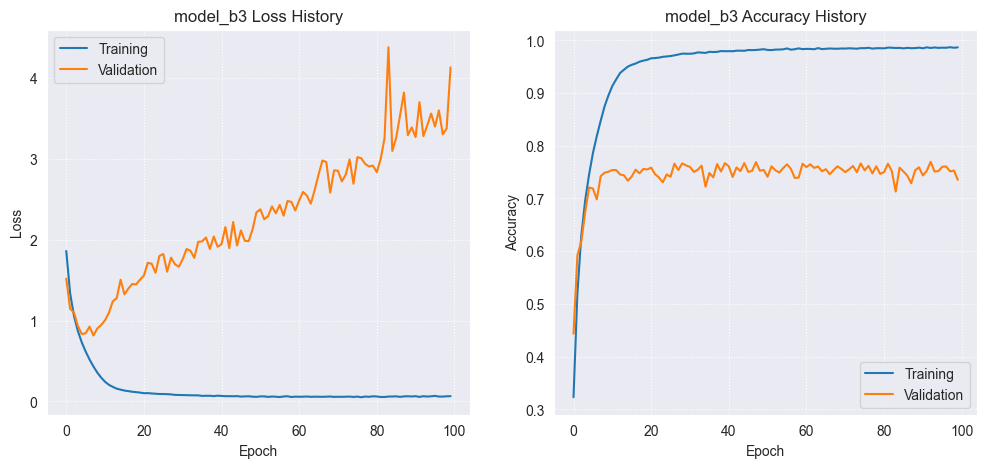

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [22]:
# example: plot any model from saved arrays
plot_history(histories_size[3], params_size[3][0])

# view block=3 model architecture, compare to unpadded block=2 model
models_size[3].summary()

## 6.2 Comparing Different Layer Sizes

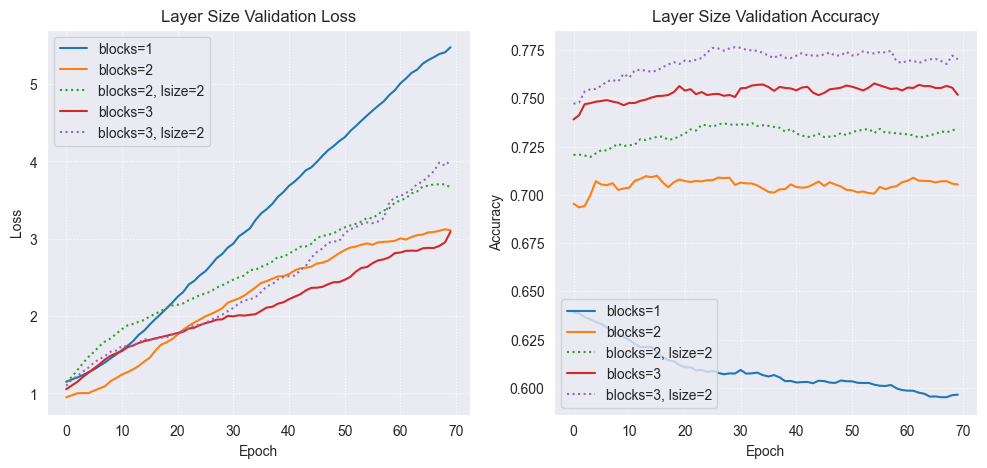

In [72]:
# plot histories of models tested so far (smoothed)
param_names = ['blocks=1',
               'blocks=2',
               'blocks=2, lsize=2',
               'blocks=3',
               'blocks=3, lsize=2']

plot_history_comparison(histories=histories_size,
                        legend_names=param_names,
                        title='Layer Size',
                        lim=80,
                        dotted=[3, 5])


### Observations & Thoughts on Layer Size
- Increasing layer size significantly boosted the top accuracy
- Doubling the layer size did not have a noticable impact on loss versus their counterpart
- **model_b2** using `blocks=2` has the lowest initial loss 
- **model_b3** using `blocks=3` has the initial loss after epoch ~20

Doubling layer size (`layer_size=2`) shows signs of overfitting. Increasing units per layer increases total weight parameters within the model, as a result the larger model learns the training set faster over the same epochs. This is most apparent when comparing hyperparameters `blocks=1` and `blocks=3`, as a larger depth learns the set better compared to a larger width. 

Adding convolutional layers was a substantial increase in performance from the baseline model. Block/stack architecture as a great approach to building better CNNs.

# 7. Regularizing and Tuning Hyperparameters

Finding optimal hyperparameters is a large spatial search problem in itself. Demonstrating and testing each type of hyperparameter can be a lengthy exploratory notebook on their own. 

For brevity, I will choose the best hyperparameters by testing 4-5 models with varying rates, then build on top of the best performing model. A combination of informed guesswork and research will help establish some basis, so the tests won't be completely blind. This approach may not be as comphrensive as a grid search method, or extensive as a random search- rather it is kept short for conciseness and efficient computational time.

Our current models from layer size testing are severly overfit. The following sections will sequentially test appropriate dropout, optimizers, and regularizers.

In [24]:
# new model for testing regularization hyperparameters

def conv2d_with_reg(blocks=1, layer_size=1, padding='same',
                    dropout=[0.0, 0.0, 0.0, 0.0],
                    optimizer='rmsprop',
                    regularizer=None):
    """
    conv2d model with more regularization options
    otherwise no major differences from conv2d_model
    """

    model = models.Sequential()

    # block 1
    model.add(layers.Conv2D(32 * layer_size, (3, 3),
                            activation='relu',
                            padding=padding,
                            kernel_regularizer=regularizer,
                            input_shape=X_train[0].shape))
    model.add(layers.Conv2D(32 * layer_size, (3, 3),
                            activation='relu',
                            padding=padding,
                            kernel_regularizer=regularizer))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(dropout[0]))

    # block 2
    if blocks > 1:
        model.add(layers.Conv2D(64 * layer_size, (3, 3),
                                activation='relu',
                                padding=padding,
                                kernel_regularizer=regularizer))
        model.add(layers.Conv2D(64 * layer_size, (3, 3),
                                activation='relu',
                                padding=padding,
                                kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout[1]))

    # block 3
    if blocks > 2:
        model.add(layers.Conv2D(128 * layer_size, (3, 3),
                                activation='relu',
                                padding=padding,
                                kernel_regularizer=regularizer))
        model.add(layers.Conv2D(128 * layer_size, (3, 3),
                                activation='relu',
                                padding=padding,
                                kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout[2]))

    # head
    model.add(layers.Flatten())
    model.add(layers.Dense(64 * np.power(2, blocks-1) * layer_size,
                           activation='relu',
                           kernel_regularizer=regularizer))
    model.add(layers.Dropout(dropout[3]))
    model.add(layers.Dense(10, activation='softmax'))

    # hyperparameter functions
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


## 7.1 Dropout Testing

To start, we will test models with `blocks=2` and `blocks=3` depth with blanket rates of 0.25, 0.5, and a gradual increasing range [0.2, 0.5]. The dropout layer will be applied after each maxpooling layer.

We will restrict the max dropout to 0.5 as per Park and Kwak's advice:
> "If higher drop probability such as 0.5 is applied in convolutional layers, CNNs perform poor or cannot be trained at all." [[3](http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf)]

Each value in the array `dropout=[0.2,  0.3,  0.4,  0.5]` corresponds to the dropout rate applied to the block in the model, ie. dropout of 0.2 gets applied after the first block, 0.3 after the second block, etc.

In [25]:
# test models with varying dropout rates

"""
The following code is equivalent to training and evaluating models:
model_d1 = conv2d_with_reg(blocks=2, dropout=[0.25, 0.25, 0.25], padding='valid)
model_d2 = conv2d_with_reg(blocks=2, dropout=[0.2,  0.3, 0.5], padding='valid)
model_d3 = conv2d_with_reg(blocks=3, dropout=[0.25, 0.25, 0.25, 0.25])
model_d4 = conv2d_with_reg(blocks=3, dropout=[0.5,  0.5,  0.5,  0.5])
model_d5 = conv2d_with_reg(blocks=3, dropout=[0.2,  0.3,  0.4,  0.5])
"""

N_EPOCHS = 100
BATCH_SIZE = 128

# define hyperparameters for models, each element represents a model
params_drop = [['model_d1', 2, [0.25, 0.25, 0.25], 'valid'],
               ['model_d2', 2, [0.2,  0.3, 0.5],   'valid'],
               ['model_d3', 3, [0.25, 0.25, 0.25, 0.25], 'same'],
               ['model_d4', 3, [0.5,  0.5,  0.5,  0.5],  'same'],
               ['model_d5', 3, [0.2,  0.3,  0.4,  0.5],  'same']]

models_drop = []
histories_drop = []

# loop over hyperparameters and create models
for i, param in enumerate(params_drop):
    model = conv2d_with_reg(blocks=param[1],
                            dropout=param[2],
                            padding=param[3])

    # train model
    history = model.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=0)

    # save model and history in arrays
    models_drop.append(model)
    histories_drop.append(history)

    # evaluate loss and accuracy data
    print(f'------------{param[0]}------------')
    loss_test, accu_test = evaluate_model(model)
    loss_epoch, accu_epoch = optimal_epoch(history)
    lowest_loss = history.history['val_loss'][loss_epoch]

    # store results for dataframe
    layer_size = 64 * np.power(2, param[1]-1)
    model_summary.append([param[0], N_EPOCHS, BATCH_SIZE, param[1], layer_size, model.count_params(),
                          param[2], 'rmsprop', '-', loss_epoch, lowest_loss, loss_test, accu_test])


# check models and histories are saved at end of runtime
print(f'{len(models_drop)} models and {len(histories_drop)} histories saved')


------------model_d1------------
Test loss: 0.7677233815193176
Test accu: 0.7818000316619873
Min loss at epoch: 27
Max accu at epoch: 63
------------model_d2------------
Test loss: 0.8147993087768555
Test accu: 0.7518000602722168
Min loss at epoch: 22
Max accu at epoch: 48
------------model_d3------------
Test loss: 0.679671049118042
Test accu: 0.7893000245094299
Min loss at epoch: 93
Max accu at epoch: 47
------------model_d4------------
Test loss: 0.8680800199508667
Test accu: 0.6996000409126282
Min loss at epoch: 87
Max accu at epoch: 87
------------model_d5------------
Test loss: 0.7137869596481323
Test accu: 0.7666000127792358
Min loss at epoch: 62
Max accu at epoch: 62
5 models and 5 histories saved


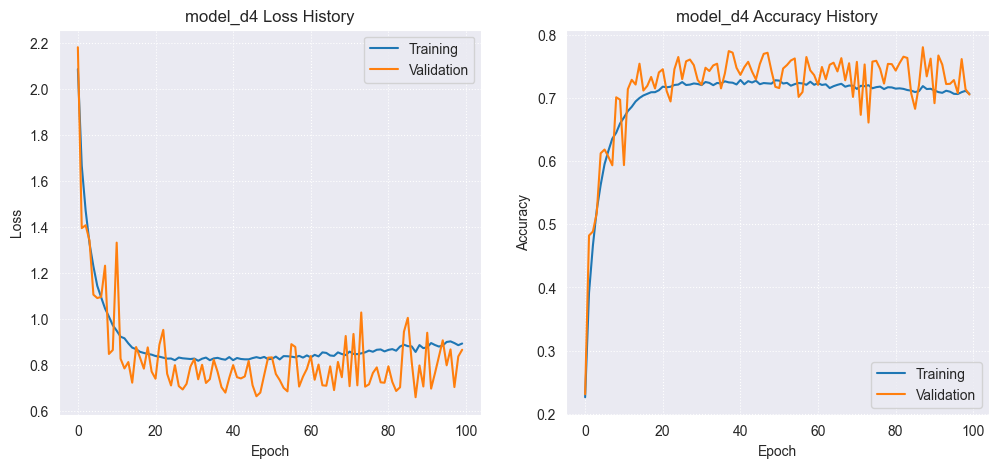

In [94]:
# plot a model with dropout from saved arrays
plot_history(histories_drop[3], params_drop[3][0])

## 7.2 Comparison of Dropouts


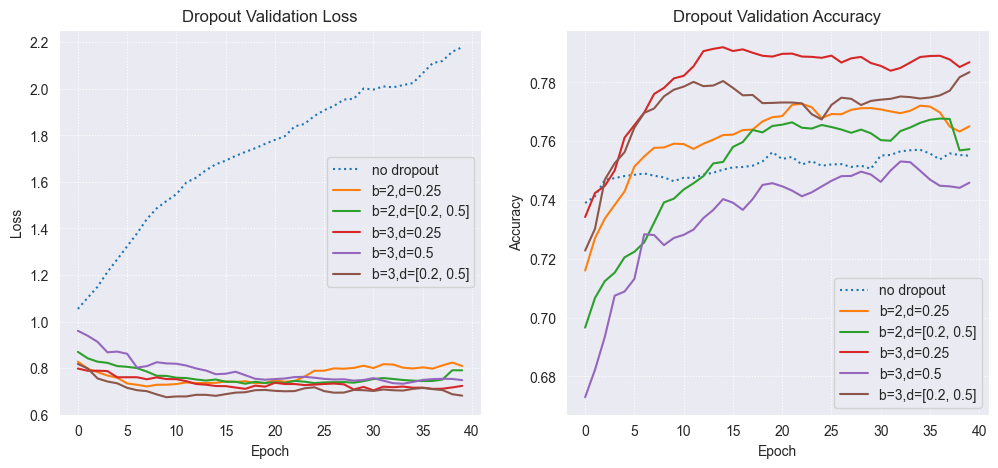

In [92]:
# plot histories of models with dropout (smoothed)
histories = [histories_size[3], histories_drop[0],
             histories_drop[1], histories_drop[2],
             histories_drop[3], histories_drop[4]]

param_names = ['no dropout', 'b=2,d=0.25',
               'b=2,d=[0.2, 0.5]', 'b=3,d=0.25',
               'b=3,d=0.5', 'b=3,d=[0.2, 0.5]']

plot_history_comparison(histories=histories,
                        legend_names=param_names,
                        title='Dropout',
                        lim=50, dotted=[1])

### Observations & Thoughts on Dropout
- Adding dropout between blocks significantly improved the validation loss curve
- models with `blocks=2` converges much eariler, but `blocks=3` performs better long term
- Increased dropout in sequential layers has slower convergence but lower loss

**model_d5** with `dropout=[0.2, 0,3, 0,4, 0.5]` has little to no difference compared to **model_d3** with `dropout=0.25`. Both dropout rates eventually converge to similar values. This leads me to believe the first input layers are the most sensitive to high dropout. This can be further evidenced by [Nikolaos's Chlis blog](https://nchlis.github.io/2017_08_10/page.html) on the matter, where he says
> "...shallower convolutional blocks are more sensitive to Dropout... As we go deeper into the network, higher values of Dropout can be used." [[4](https://nchlis.github.io/2017_08_10/page.html)]

## 7.3 Optimizer Testing

By default Keras sets the default learning rate to 1e-3 for all optimizers. Since we've already been using rmsprop to this point and see signs of overfitting, we'll adjust the learning rate to a lower one and add in decay. Adagrad is another one we'll test which recommends a higher learning rate [[5](https://keras.io/api/optimizers/adagrad/)] so we'll raise it before training as well.

In this section we'll test different optimizers:
- **rmsprop** with learning_rate=1e-4, decay=1e-6
- **adagrad** with learning_rate=1e-2
- **adam** with learning_rate=1e-3
- **SGD** with learning_rate=1e-3

We'll use the best performing dropout rate learned from the previous section, `dropout=[0.2,  0.3,  0.4,  0.5]` for all models.

In [28]:
"""
The following code is equivalent to training and evaluating models:
model_or = conv2d_with_reg(blocks=3, dropout=[0.2,  0.3,  0.4,  0.5], optimizer=OPT_1)
model_og = conv2d_with_reg(blocks=3, dropout=[0.2,  0.3,  0.4,  0.5], optimizer=OPT_2)
model_oa = conv2d_with_reg(blocks=3, dropout=[0.2,  0.3,  0.4,  0.5], optimizer='adam')
model_os = conv2d_with_reg(blocks=3, dropout=[0.2,  0.3,  0.4,  0.5], optimizer='SGD')
# note: default learning rate for all keras optimizers is 0.001
"""
N_EPOCHS = 200
BATCH_SIZE = 128
OPT_1 = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)
OPT_2 = optimizers.Adagrad(learning_rate=0.01)

opt_names=['rmsprop*', 'adagrad', 'adam', 'SGD']

# define hyperparameters for models, each element represents a model
params_opt = [['model_or', 3, [0.2,  0.3,  0.4,  0.5], OPT_1],
              ['model_og', 3, [0.2,  0.3,  0.4,  0.5], OPT_2],
              ['model_oa', 3, [0.2,  0.3,  0.4,  0.5], 'adam'],
              ['model_os', 3, [0.2,  0.3,  0.4,  0.5], 'SGD']]

models_opt = []
histories_opt = []

# loop over hyperparameters and create models
for i, param in enumerate(params_opt):
    model = conv2d_with_reg(blocks=param[1],
                            dropout=param[2],
                            optimizer=param[3])

    # train model
    history = model.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=0)

    # save model and history in arrays
    models_opt.append(model)
    histories_opt.append(history)

    # evaluate loss and accuracy data
    print(f'------------{param[0]}------------')
    loss_test, accu_test = evaluate_model(model)
    loss_epoch, accu_epoch = optimal_epoch(history)
    lowest_loss = history.history['val_loss'][loss_epoch]

    # store results for dataframe
    layer_size = 64 * np.power(2, param[1]-1)
    model_summary.append([param[0], N_EPOCHS, BATCH_SIZE, param[1], layer_size, model.count_params(),
                          param[2], opt_names[i], '-', loss_epoch, lowest_loss, loss_test, accu_test])


# check models and histories are saved at end of runtime
print(f'{len(models_opt)} models and {len(histories_opt)} histories saved')


------------model_or------------
Test loss: 0.5424136519432068
Test accu: 0.8336000442504883
Min loss at epoch: 196
Max accu at epoch: 195
------------model_og------------
Test loss: 0.5301392078399658
Test accu: 0.8256000280380249
Min loss at epoch: 184
Max accu at epoch: 183
------------model_oa------------
Test loss: 0.6125898361206055
Test accu: 0.83160001039505
Min loss at epoch: 40
Max accu at epoch: 138
------------model_os------------
Test loss: 0.5377488732337952
Test accu: 0.8194000124931335
Min loss at epoch: 191
Max accu at epoch: 193
4 models and 4 histories saved


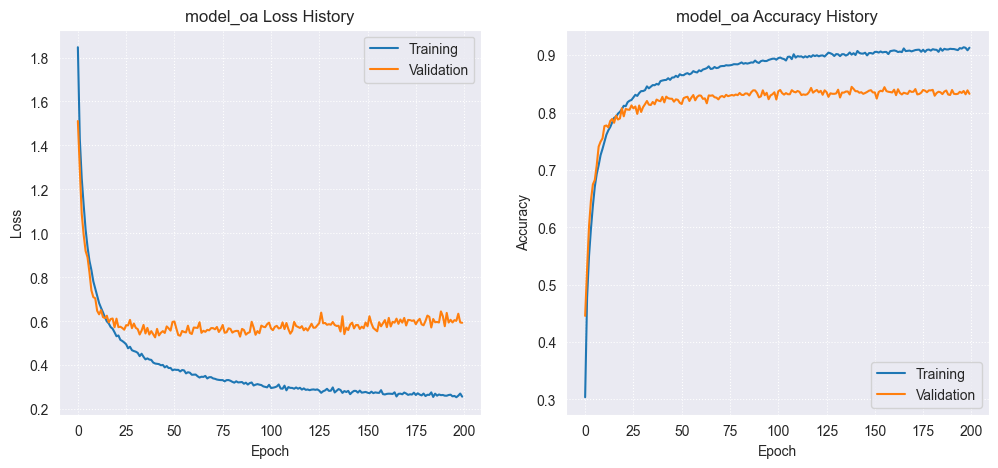

In [98]:
# plot the adam optimizer model from saved arrays
plot_history(histories_opt[2], params_opt[2][0])

## 7.4 Comparison of Optimizers


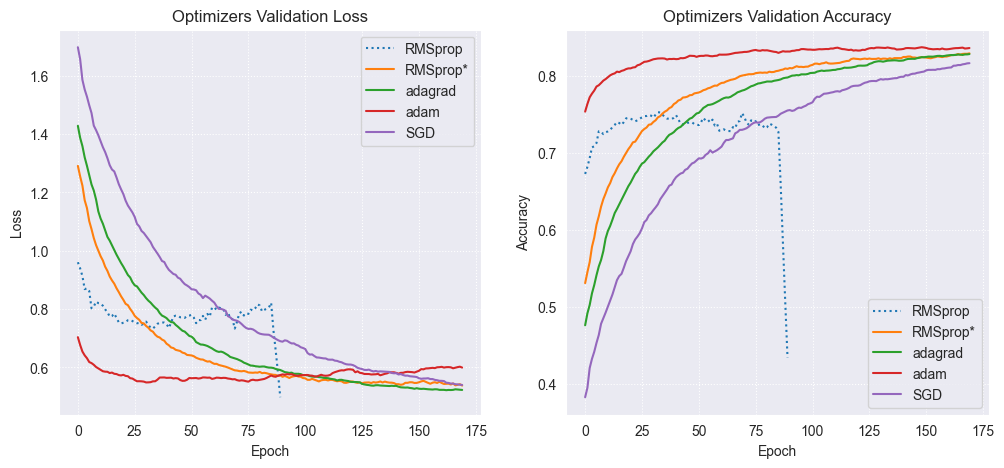

In [97]:
# plot histories of models with optimizers (smoothed)
histories = [histories_drop[3], histories_opt[0],
             histories_opt[1], histories_opt[2], histories_opt[3]]
param_names = ['RMSprop', 'RMSprop*', 'adagrad', 'adam', 'SGD']

plot_history_comparison(histories=histories,
                        legend_names=param_names,
                        title='Optimizers',
                        lim=180, dotted=[1])

### Observations & Thoughts on Optimizers
- Lowering the learning rate of optimizers improves loss over longer training periods
- The default `rmsprop` training curve is very noisy, lower learning rate is needed
- `rmsprop*` with an adjusted learning rate and decay converages slower but matches scores of `adam`
- `adam` converges much eariler than the other optimizers
- The current `adagrad` learning rate is too high and begins to overfit
- `SGD` performs very well without tuning

In general, all the optimizers here perform pretty well, and each can have their learning rates tuned individually to better fit the data. Eg. `adagrad` works well with a higher learning rate than `rmsprop`. All optimizers perform similarity, and at this point, any can be used interchangably given tuning. 

Based on minimum validation loss achieved, `rmsprop` may potentially perform better than other optimizers with longer training epochs, therefore it will be used as the main optimizer moving forward. 

## 7.5 Regularizer Testing

Here we'll test both L1 and L2 regularizers with `dropout=[0.2,  0.3,  0.4,  0.5]` and the adjusted `rmsprop` optimizer. Our models are taking longer to converge with now, so epochs will also be increased to 200.

In [30]:
# test different L1 and L2 regularization rates

"""
The following code is equivalent to training and evaluating models:
model_l1a = conv2d_with_reg(blocks=3, dropout=[0.2,  0.3,  0.4,  0.5], optimizer=OPT, regularizer=REG_1)
model_l1b = conv2d_with_reg(blocks=3, dropout=[0.2,  0.3,  0.4,  0.5], optimizer=OPT, regularizer=REG_2)
model_l2a = conv2d_with_reg(blocks=3, dropout=[0.2,  0.3,  0.4,  0.5], optimizer=OPT, regularizer=REG_3)
model_l2b = conv2d_with_reg(blocks=3, dropout=[0.2,  0.3,  0.4,  0.5], optimizer=OPT, regularizer=REG_4)
"""

N_EPOCHS = 200
BATCH_SIZE = 128

OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)
REG_1 = regularizers.l1(1e-4)
REG_2 = regularizers.l1(1e-5)
REG_3 = regularizers.l2(1e-4)
REG_4 = regularizers.l2(1e-5)

reg_rates = ['l1=1e-4', 'l1=1e-5', 'l2=1e-4', 'l2=1e-5']

# define hyperparameters for models, each element represents a model
params_reg = [['model_l1a', 3, [0.2,  0.3,  0.4,  0.5], REG_1],
              ['model_l1b', 3, [0.2,  0.3,  0.4,  0.5], REG_2],
              ['model_l2a', 3, [0.2,  0.3,  0.4,  0.5], REG_3],
              ['model_l2b', 3, [0.2,  0.3,  0.4,  0.5], REG_4]]

models_reg = []
histories_reg = []

# loop over hyperparameters and create models
for i, param in enumerate(params_reg):
    model = conv2d_with_reg(blocks=param[1],
                            dropout=param[2],
                            optimizer=OPT_1,
                            regularizer=param[3])

    # train model
    history = model.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=0)

    # save model and history in arrays
    models_reg.append(model)
    histories_reg.append(history)

    # evaluate loss and accuracy data
    print(f'------------{param[0]}------------')
    loss_test, accu_test = evaluate_model(model)
    loss_epoch, accu_epoch = optimal_epoch(history)
    lowest_loss = history.history['val_loss'][loss_epoch]

    # store results for dataframe
    layer_size = 64 * np.power(2, param[1]-1)
    model_summary.append([param[0], N_EPOCHS, BATCH_SIZE, param[1], layer_size, model.count_params(),
                          param[2], 'rmsprop*', reg_rates[i], loss_epoch, lowest_loss, loss_test, accu_test])


# check models and histories are saved at end of runtime
print(f'{len(models_reg)} models and {len(histories_reg)} histories saved')


------------model_l1a------------
Test loss: 0.9788398146629333
Test accu: 0.7817000150680542
Min loss at epoch: 193
Max accu at epoch: 198
------------model_l1b------------
Test loss: 0.7321604490280151
Test accu: 0.8317000269889832
Min loss at epoch: 137
Max accu at epoch: 191
------------model_l2a------------
Test loss: 0.6735953688621521
Test accu: 0.8220000267028809
Min loss at epoch: 195
Max accu at epoch: 195
------------model_l2b------------
Test loss: 0.5598933100700378
Test accu: 0.826900064945221
Min loss at epoch: 183
Max accu at epoch: 198
4 models and 4 histories saved


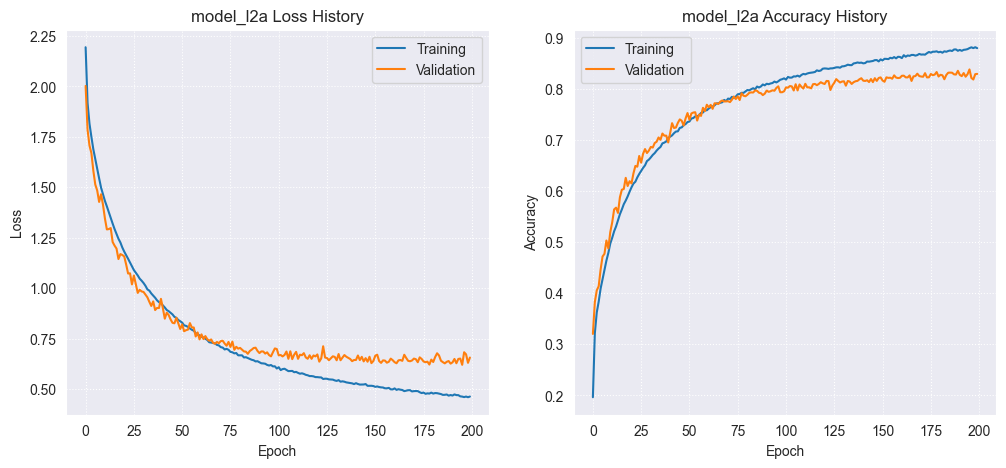

In [99]:
# plot l2=1e=4 model from saved arrays
plot_history(histories_reg[2], params_reg[2][0])

## 7.6 Comparison of Regularizers


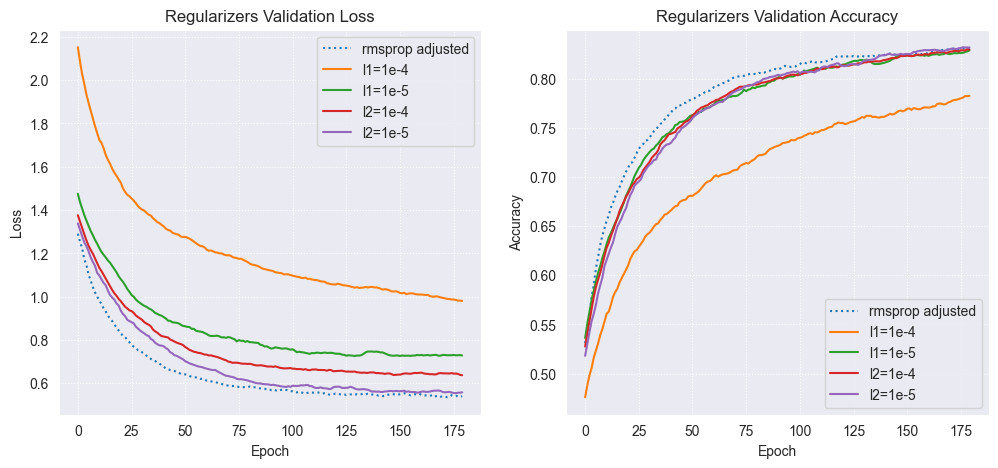

In [69]:
# plot histories of models with regularizers (smoothed)
histories = [histories_opt[0], histories_reg[0],
             histories_reg[1], histories_reg[2], histories_reg[3]]
params = ['rmsprop adjusted', 'l1=1e-4', 'l1=1e-5', 'l2=1e-4', 'l2=1e-5']

plot_history_comparison(histories=histories,
                        legend_names=params,
                        title='Regularizers',
                        lim=190, dotted=[1])

### Observations & Thoughts on Regularizers
- L1 penalizes weights significantly more than L2
- Both L1 and L2 seem to 'horizontally shift' the validation curves without noticable changes in shape
- Lower rates of regularization give the lowest validation loss
- In all tested cases, applying regularization to the model is worse than without

It may be possible the current model architecture and tuned optimizer is already good enough without the use of L1/L2 regularizers. If the order of testing hyperparameters was regularizers before optimizers, it may be possible to show a better application of regularizers in different situations. For example, high L2 may find compromise with the `adam` optimizer. 

To continue and evaluate based on validation loss, the final model will omit the use of regularizers.

# 8. Testing and Evaluation

We gained enough information to train one last model. The final training set will have 50,000 samples, combining the validation and partial sets into one again. The final model will also use the following hyperparameters:
- `blocks=3`
- `dropout=[0.2,  0.3,  0.4,  0.5]`
- `optimizer=optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)`
- `regularizer=None`

In [32]:
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

# adjusted rmsprop model without regularizers
training_model = conv2d_with_reg(blocks=3, dropout=[0.2,  0.3,  0.4,  0.5], optimizer=OPT)
training_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_97 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_98 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_99 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

In [33]:
# partial training set to find optimal epoch

N_EPOCHS = 200
BATCH_SIZE = 128


training_history = training_model.fit(x_partial, y_partial,
                        validation_data=(x_val, y_val),
                        epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                        verbose=0)

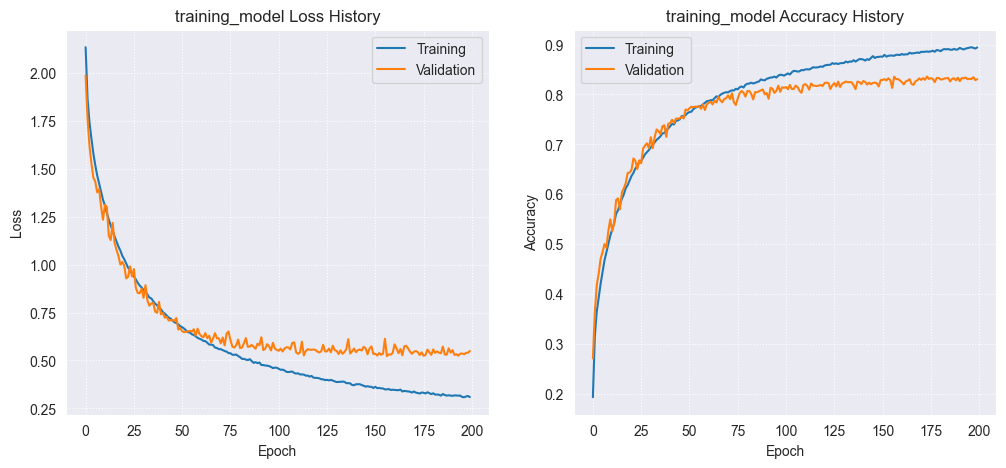

In [34]:
plot_history(training_history, 'training_model')

In [35]:
# evaluate loss and accuracy with testing set
loss_test, accu_test = evaluate_model(training_model)

# print optimal epoch from training history
loss_epoch, accu_epoch = optimal_epoch(training_history)
lowest_loss = training_history.history['val_loss'][loss_epoch]

# store results
layer_size = 64 * np.power(2, param[1]-1)
model_summary.append(['training_model', N_EPOCHS, BATCH_SIZE, layer_size, 32, training_model.count_params(),
                     [0.2,  0.3,  0.4,  0.5], 'rmsprop*', '-', loss_epoch, lowest_loss, loss_test, accu_test])

Test loss: 0.5460476279258728
Test accu: 0.8272000551223755
Min loss at epoch: 156
Max accu at epoch: 173


## 8.1 Cohesive Training Set


In [36]:
OPT = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6)

# final combined training set model
final_model = conv2d_with_reg(blocks=3, dropout=[0.2,  0.3,  0.4,  0.5], optimizer=OPT)
final_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_103 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_54 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_104 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_105 (Conv2D)         (None, 16, 16, 64)        36928     
                                                     

In [101]:
# convergence is noisy, optimal epoch can vary between 120-200
print(f'The optimal epoch is {loss_epoch}')

The optimal epoch is 156


In [37]:
N_EPOCHS = loss_epoch 
BATCH_SIZE = 128

# final combined training set
X_train_t = prep_normalize(X_train)
y_train_t = prep_encoder(y_train)

final_history = final_model.fit(X_train_t, y_train_t,
                                epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                                verbose=0)

In [38]:
loss_test, accu_test = evaluate_model(final_model)
# no val_loss to evaluate with final model

# save final model as .keras file
final_model.save('cifar10_CNN.keras')
# model = tf.keras.models.load_model('cifar10_CNN.keras')

# store results
layer_size = 64 * np.power(2, param[1]-1)
model_summary.append(['final_model', N_EPOCHS, BATCH_SIZE, 3, layer_size, final_model.count_params(),
                     [0.2,  0.3,  0.4,  0.5], 'rmsprop*', '-', '-', loss_test, loss_test, accu_test])


Test loss: 0.497840940952301
Test accu: 0.8403000235557556


## 8.2 Evaluating the Final Model

In this last section, examining some of the correct and incorrect predictions may give us insight as to how the final model performs on the testing data. Naively, we can analyze the results by plotting the incorrect predictions to try and undertand which classes the model has trouble identifying.

Number of incorrect predictions: 1597/10000
Error rate: 0.1597
10 incorrect predictions, index=684


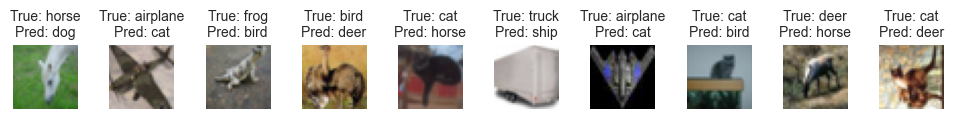

In [39]:
# use final trained final_model to predict testing data
y_pred = final_model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

# get index count of false predictions
errors = np.sum(y_pred != y_test)
errors_index = np.where(y_pred != y_test)[0]
test_samples = len(y_pred)

print(f'Number of incorrect predictions: {errors}/{test_samples}')
print(f'Error rate: {errors/test_samples}')

# plot incorrect preditions, true vs predicted labels
low = np.random.randint(10, len(errors_index)-10)
high = low + 10

plot_multi_sample(X_test[errors_index][low:high],
                  y_test[errors_index][low:high].ravel(),
                  y_pred[errors_index][low:high],
                  name=f'incorrect predictions, index={low}')

10 correct predictions, index=7984


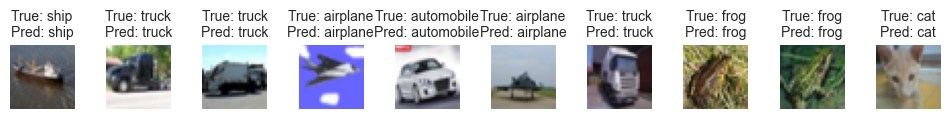

In [40]:
# plot correct preditions
correct_index = np.where(y_pred == y_test)[0]

# generate random index
low = np.random.randint(10, len(correct_index)-10)
high = low + 10

plot_multi_sample(X_test[correct_index][low:high],
                  y_test[correct_index][low:high].ravel(),
                  y_pred[correct_index][low:high],
                  name=f'correct predictions, index={low}')


total=1597


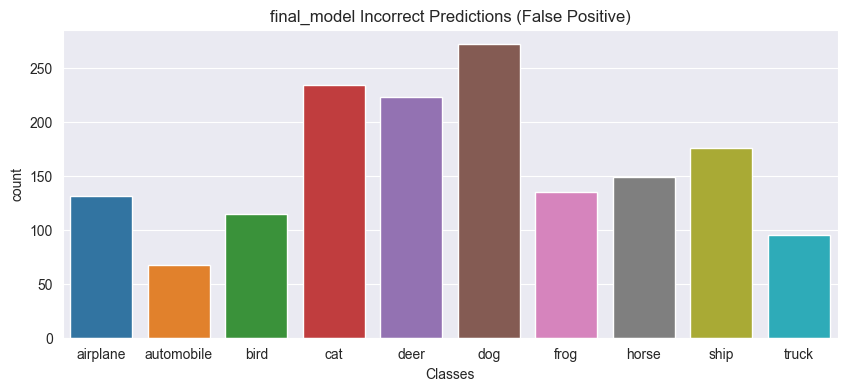

In [41]:
# plot y_pred with errors index
plot_pred_count(y_data=y_pred,
                 index=errors_index,
                 title='final_model Incorrect Predictions (False Positive)')

total=8403


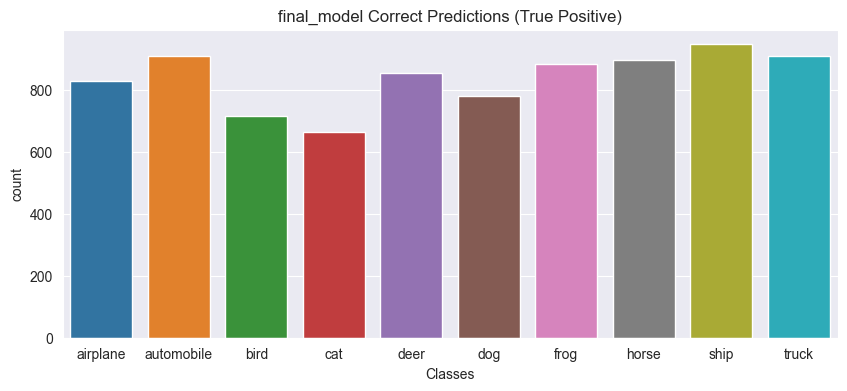

In [42]:
# plot y_pred with correctly predicted index
plot_pred_count(y_data=y_pred,
                 index=correct_index,
                 title='final_model Correct Predictions (True Positive)')

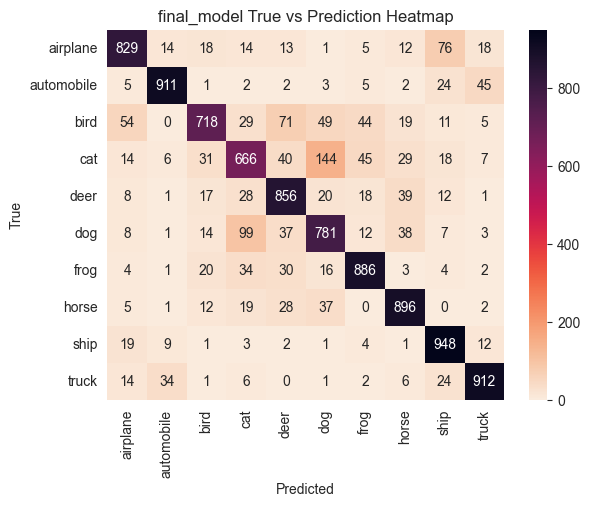

In [43]:
plot_pred_heatmap(y_test, y_pred, 'final_model')

In [44]:
# get a report of model metrics
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).round(2).transpose()

display(report_df)

,precision,recall,f1-score,support
0,0.86,0.83,0.85,1000.00
1,0.93,0.91,0.92,1000.00
2,0.86,0.72,0.78,1000.00
3,0.74,0.67,0.70,1000.00
4,0.79,0.86,0.82,1000.00
5,0.74,0.78,0.76,1000.00
6,0.87,0.89,0.88,1000.00
7,0.86,0.90,0.88,1000.00
8,0.84,0.95,0.89,1000.00
9,0.91,0.91,0.91,1000.00


### Observations & Thoughts after Model Evaluation
- **final_model** performs well with test set, loss: 0.498 and accuracy 0.840
- **final_model** incorrectly predicts classes 'cat', 'deer', and 'dog' approximately twice as much as than other classes
- A confusion matrix shows the model has trouble learning to distinguish between 'bird', 'cat', and 'dog'
- The model is able to predict other classes with high accuracy

My first thought after examining the predictions is "Why did the model fail to identify the central classes? And why did it incorrectly guess 'dog' and 'cat' the most?. I wonder if reducing the colour variance by flattening the RGB channels to greyscale may improve learning. Could it be a data set problem?".

I noticed during training most of the models converged around 0.6 val_loss and 0.8 val_accuracy, so I decide to examine a similar model, model_oa, which used similar hyperparameters as **final_model**.

total=1684


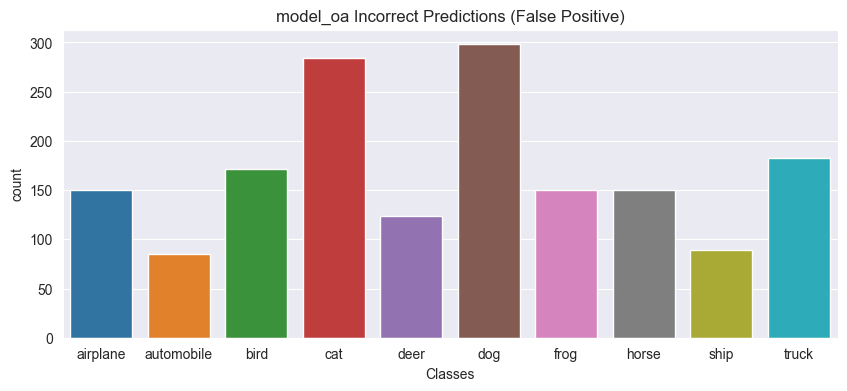

In [79]:
# examine y_pred from model_oa
y_pred_a = models_opt[2].predict(x_test, verbose=0)
y_pred_a = np.argmax(y_pred_a, axis=1)

# get index count of false predictions
errors = np.sum(y_pred_a != y_test)
errors_index = np.where(y_pred_a != y_test)[0]
test_samples = len(y_pred_a)

plot_pred_count(y_data=y_pred_a,
                index=errors_index,
                title='model_oa Incorrect Predictions (False Positive)')

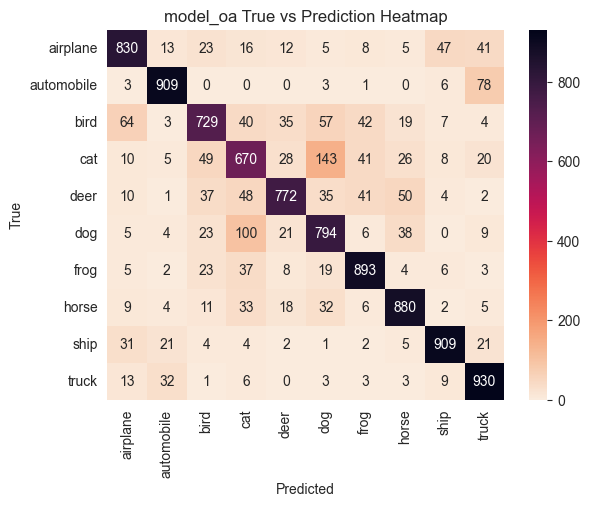

In [46]:
plot_pred_heatmap(y_test, y_pred_a, 'model_oa')

### Examining another Model
Compared to final_model, there are some similarities with model_oa:
- 'bird', 'cat', 'deet', and 'dog' were not learned properly
- false predictions are centralized

In contrast:
- **model_oa** is a worse predictor of 'deer' than final_model
- **model_oa** has less precision with classes 'cat' and 'dog'

This appears to be a rooted learning problem reoccuring with multiple models, and troubleshooting requires re-examination at the architecture level. Otherwise, if 'cat' and 'dog' is hard to distinguish due to inability to extract different features, this could be a problem with the data set that requires extra feature engineering at the preprocessing stage. It would not be something adjusting hyperparameters could fix.

# 9. Conclusion

The final model trained from culminative testing is able to achieve a respectable predictive accuracy of 84%, up from the 40% from the baseline model. It is capable of correctly predicting seven of the original labels from the `cifar10` data set with high precision, but may still fall short of an average human skill level. 

Validating with a hold-out set, we were able to show that adding depth and regularization to a convolutional deep learning model significantly improves its predictive power. Regularization is vital to reducing overfitting by penalizing aspects of the learning during the training stage. Finding optimal hyperparameters is a large search space problem, but one can narrow the area by taking observational testing approaches and making reasonably educated guesses. Tuning is still required on a case-by-case basis, hence understanding the context of the data set is important creating a good deep learning model.

In total, 20 models have been trained for the purposes of this task, with each showing minor improvements over the last. One sweeping issue was the weaker ability for late models to distinguish between the 'dog' and 'cat' classes. This appears to be a local minima in the gradient space further tuning could not tame, perhaps requiring revising the architecture design or the data set features.

In [3]:
# create dataframe
column_names = ['name', 'epochs', 'batch_size', 'blocks', 'layer_size', 'parameters',
                'dropout', 'optimizer', 'regularizer', 'fit epoch', 'lowest loss', 'test loss', 'test accu']

model_df = pd.DataFrame(model_summary, columns=column_names).round(2)
# model_df.set_index('name', inplace=True)

# export df as csv
model_df.to_csv('model_summary.csv', index=False)

display(model_df)
print('rmsprop* has learning_rate=1e-4, decay=1e-6')

,name,epochs,batch_size,blocks,layer_size,parameters,dropout,optimizer,regularizer,fit epoch,lowest loss,test loss,test accu
0,base_model,100,64,0,32,327818,-,rmsprop,-,4,1.50,2.66,0.40
1,model_b1,100,128,1,64,412266,-,rmsprop,-,3,1.04,6.62,0.59
2,model_b2,100,128,2,128,271786,-,rmsprop,-,9,0.83,3.58,0.70
3,model_b2s2,100,128,2,256,1082186,-,rmsprop,-,5,0.85,4.40,0.74
4,model_b3,100,128,3,256,814122,-,rmsprop,-,7,0.82,4.24,0.73
5,model_b3s2,100,128,3,512,3248202,-,rmsprop,-,3,0.79,6.52,0.77
6,model_d1,100,128,2,128,271786,"[0.25, 0.25, 0.25]",rmsprop,-,27,0.68,0.77,0.78
7,model_d2,100,128,2,128,271786,"[0.2, 0.3, 0.5]",rmsprop,-,22,0.69,0.81,0.75
8,model_d3,100,128,3,256,814122,"[0.25, 0.25, 0.25, 0.25]",rmsprop,-,93,0.62,0.68,0.79
9,model_d4,100,128,3,256,814122,"[0.5, 0.5, 0.5, 0.5]",rmsprop,-,87,0.66,0.87,0.70


rmsprop* has learning_rate=1e-4, decay=1e-6


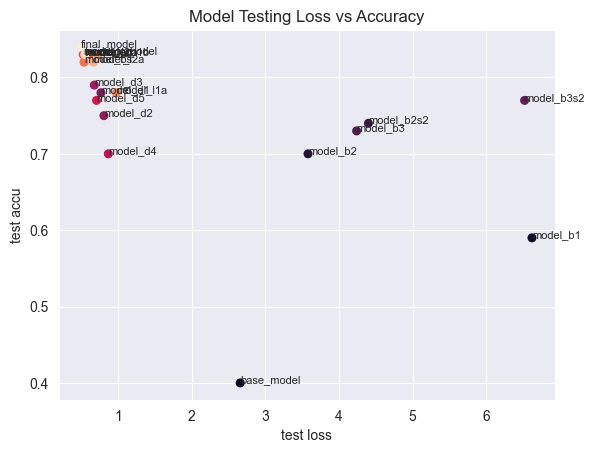

In [48]:
# split model_df by column
plot_df = model_df.loc[:, ['name', 'test loss', 'test accu']]
plot_df.set_index('name', inplace=True)

# adapted from [1] #answer-26000515
fig, ax = plt.subplots()
plot_df.plot(x='test loss', y='test accu', kind='scatter',
             ax=ax, s=30, c=range(len(plot_df)), title='Model Testing Loss vs Accuracy')

# plot and annotate points
for k, v in plot_df.iterrows():
    ax.annotate(k, v, xytext=(v[0], v[1]), fontsize=8)

## Reflection

The process of finding optimal hyperparameters was most challenging. Trying to strike a balance between computational power and optimal settings meant I dedicated most of my time blindly running new models without knowing if they were going to be effective or not. As a result, many models tested is not shown in this notebook. Even if there are good papers or online discussions about the topic I was inquirying, sometimes even down to the exact same data set I was using, settings were still largely subjectively and minor setting differences meant no two results were ever exactly the same. This extended to my own models that I trained, because re-training them with noisy optimizers often gave different results to interpret.

At some point when I learned about the grid/random search technique, I realized hyperparameter tuning was similar to searching a stochastic space for optimal parameters- the exact thing we're doing with machine learning can be applied to machine learning!

Some other possible improvements:
- batch normalization is another regularization technique proven to be effective that could have been applied
- data augmentation was something that was alluded to that may help distinguish between 'cats' and 'dogs'
- calculating the average model scores would have been a more effective metric to differentiate close results
- showing ROC graphs and AUC scores would be better for comparison in some cases

# References


https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf [1] alexnet

https://arxiv.org/pdf/1409.1556.pdf [2] vgg16

http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf [3]

https://nchlis.github.io/2017_08_10/page.html [4]

https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

https://keras.io/api/layers/convolution_layers/convolution2d/ [5]

https://tanthiamhuat.files.wordpress.com/2018/03/deeplearningwithpython.pdf [6]

https://stackoverflow.com/questions/17888593/display-sequence-of-images-using-matplotlibmatpl

https://cs231n.github.io/

https://web.eecs.umich.edu/~justincj/teaching/eecs498/FA2020/

https://matplotlib.org/stable/index.html

https://stackoverflow.com/questions/15910019/annotate-data-points-while-plotting-from-pandas-dataframe#answer-26000515

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu


### Misc. GPU Testing


In [49]:
# native Windows tensorflow=2.10
!nvidia-smi


Sat Sep 16 15:03:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080      WDDM  | 00000000:01:00.0  On |                  N/A |
| 31%   57C    P0              52W / 172W |   7940MiB /  8192MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [50]:
# Look for GPU
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))


/device:GPU:0
Found GPU at: /device:GPU:0


In [51]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
